In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow as tf
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
# resize the image
IMAGE_RESIZE_X = 200
IMAGE_RESIZE_Y = 200

# Read car images and resize them

In [3]:
car_folder_path = '/content/drive/MyDrive/rawData/images' 

car_image_name_list = list()
for car_image in os.listdir(car_folder_path):
    full_path = os.path.join(car_folder_path, car_image)
    car_image_name_list.append(full_path)
# sort the cars by their index in ascending order
car_image_name_list = sorted(car_image_name_list, key=lambda x: int(x.split('/')[-1].split('.')[0][4:]))

# read in car images and resize
resized_car_images_list = list()    
for full_path in car_image_name_list:
    car_image = cv2.imread(full_path)
    car_resize_image = cv2.resize(car_image, (IMAGE_RESIZE_X, IMAGE_RESIZE_Y))
    resized_car_images_list.append(np.array(car_resize_image))

print('Read in {} resized car images'.format(len(resized_car_images_list)))

Read in 433 resized car images


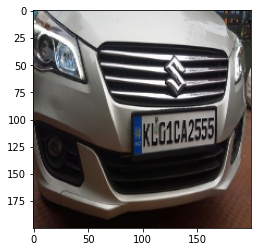

In [4]:
plt.imshow(cv2.cvtColor(resized_car_images_list[0], cv2.COLOR_BGR2RGB))

# Read licence plate annotations and resize them

In [5]:
plate_folder_path = '/content/drive/MyDrive/rawData/annotations'

plate_name_list = list()
for plate_file in os.listdir(plate_folder_path):
    full_path = os.path.join(plate_folder_path, plate_file)
    plate_name_list.append(full_path)
plate_name_list = sorted(plate_name_list, key=lambda x: int(x.split('/')[-1].split('.')[0][4:]))   

resized_plate_location_list = list()
for full_path in plate_name_list:
    xml_file = open(full_path, 'r')
    bs = BeautifulSoup(xml_file, "xml")
    
    width = int(bs.find('width').text)
    height = int(bs.find('height').text)
    
    xMax = int(bs.find('xmax').text) * (IMAGE_RESIZE_X / width)
    xMin = int(bs.find('xmin').text) * (IMAGE_RESIZE_X / width)
    yMax = int(bs.find('ymax').text) * (IMAGE_RESIZE_Y / height)
    yMin = int(bs.find('ymin').text) * (IMAGE_RESIZE_Y / height)
    resized_plate_location_list.append([int(xMax), int(xMin), int(yMax), int(yMin)])
    
print('Read in {} resized plate info'.format(len(plate_name_list)))

Read in 433 resized plate info


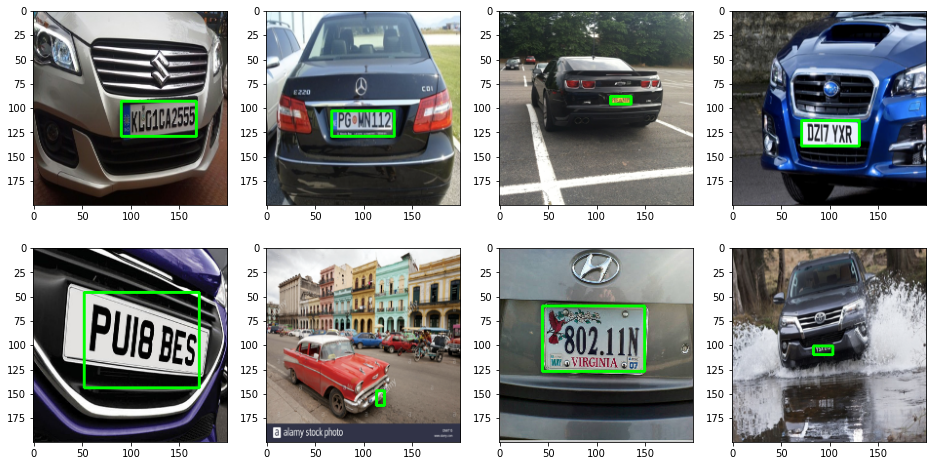

In [6]:
plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    
    # locate the plate location based on label
    top_left = (resized_plate_location_list[i][1], resized_plate_location_list[i][3])
    bottom_right = (resized_plate_location_list[i][0], resized_plate_location_list[i][2])
    
    # draw bounding box on the copy of resized car image so that we have original image to train with
    car_image_copy = resized_car_images_list[i].copy()
    
    # display the car image with plate around
    cv2.rectangle(car_image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(car_image_copy, cv2.COLOR_BGR2RGB))

In [7]:
def splitTrainTestSet():
  # X would be the array representation of resized car image
  # y would be the plate location 

  resized_car_images_list_np = np.array(resized_car_images_list)
  resized_plate_location_list_np = np.array(resized_plate_location_list)

  # normalization
  normalized_X = resized_car_images_list_np/255 # make all pixel color ranges from 0 to 1 instead of 0 to 255
  normalized_y = resized_plate_location_list_np/200

  X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, test_size=0.1, random_state=7)
  
  return X_train, X_test, y_train, y_test 

In [8]:
def setupModel(modelType):
  cnn = keras.models.Sequential()

  if modelType == 'VGG16':
    cnn.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_RESIZE_X, IMAGE_RESIZE_Y, 3)))
    cnn.add(keras.layers.Dropout(0.1))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation="relu"))
    cnn.add(Dense(128, activation="relu"))
    cnn.add(Dense(64, activation="relu"))
    # we want the output with 4 points which are the four corners of the plate
    cnn.add(Dense(4, activation="sigmoid"))
    #cnn.layers[-6].trainable = False
  
  elif modelType == 'cnn':
    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=5, input_shape=(IMAGE_RESIZE_X,IMAGE_RESIZE_Y,3), padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(keras.layers.Dropout(0.1))
    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(keras.layers.Dropout(0.1))
    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Flatten())
    # fully connected layer
    cnn.add(Dense(128, activation="relu"))
    cnn.add(Dense(64, activation="relu"))
    # we want the output with 4 points which are the four corners of the plate
    cnn.add(keras.layers.Dense(4, activation="sigmoid"))

  return cnn

In [9]:
import keras
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

cnn = setupModel(modelType='VGG16')
cnn.summary()

X_train, X_test, y_train, y_test  = splitTrainTestSet()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2

In [10]:
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

train = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 5s 577ms/step - loss: 0.0285 - accuracy: 0.5712 - val_loss: 0.0302 - val_accuracy: 0.6591
Epoch 3/50
8/8 [==============================] - 5s 593ms/step - loss: 0.0269 - accuracy: 0.5895 - val_loss: 0.0282 - val_accuracy: 0.5227
Epoch 4/50
8/8 [==============================] - 5s 569ms/step - loss: 0.0252 - accuracy: 0.6282 - val_loss: 0.0259 - val_accuracy: 0.5682
Epoch 5/50
8/8 [==============================] - 5s 567ms/step - loss: 0.0229 - accuracy: 0.7076 - val_loss: 0.0253 - val_accuracy: 0.5682
Epoch 6/50
8/8 [==============================] - 4s 560ms/step - loss: 0.0196 - accuracy: 0.7172 - val_loss: 0.0244 - val_accuracy: 0.5682
Epoch 7/50
8/8 [==============================] - 4s 561ms/step - loss: 0.0212 - accuracy: 0.7273 - val_loss: 0.0218 - val_accuracy: 0.6818
Epoch 8/50
8/8 [==============================] - 4s 558ms/step - loss: 0.0196 - accuracy: 0.7566 - val_loss: 0.0197 - val_accuracy: 0.6364
Epoch 9/50
8/8 [====

In [11]:
# Test
scores = cnn.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 81.82%


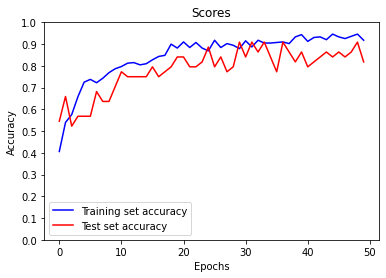

In [12]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training set accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Test set accuracy')
plt.title('Scores')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.linspace(0, 1, 11))

plt.legend()
plt.show()

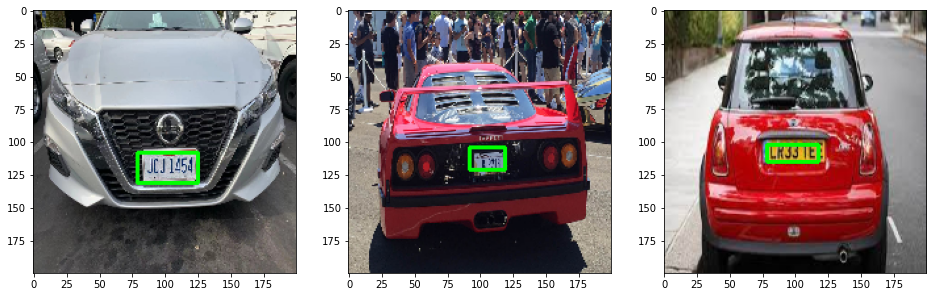

In [26]:
# read in car images and resize

test_image_folder = '/content/drive/MyDrive/rawData/'
test_image_list = ['img1.jpg', 'img5.jpg', 'img7.jpg']    
resized_test_image_list = list()
orginal_test_image_list = list()
test_image_orginal_size = list()
for test_image in test_image_list:
    full_path = os.path.join(test_image_folder, test_image)
    car_image = cv2.imread(full_path)
    orginal_test_image_list.append(car_image)
    test_image_orginal_size.append(car_image.shape)
    car_resize_image = cv2.resize(car_image, (IMAGE_RESIZE_X, IMAGE_RESIZE_Y))
    resized_test_image_list.append(np.array(car_resize_image))

resized_test_image_list = np.array(resized_test_image_list)
# normalization
# this is important because our cnn network takes normalized input
resized_test_image_list = resized_test_image_list / 255

# make prediction
plate_location = cnn.predict(resized_test_image_list)
    
# plot the result
plt.figure(figsize=(16,8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    
    # draw bounding box on the copy of resized car image so that we have original image to train with
    car_image_copy = resized_test_image_list[i].copy()
    car_image_copy = car_image_copy * 255 # get original car image size
    car_image_copy = car_image_copy.astype('uint8') # cast to uint8 so that we can plot with normal RGB color
    
    # locate the plate location based on label
    # the output of the cnn is still normalized output, so we need to get the original dimension
    top_left = (int(plate_location[i][1] * 200), int(plate_location[i][3] * 200))
    bottom_right = (int(plate_location[i][0] * 200), int(plate_location[i][2] * 200))

    # display the car image with plate
    cv2.rectangle(car_image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(car_image_copy, cv2.COLOR_BGR2RGB))

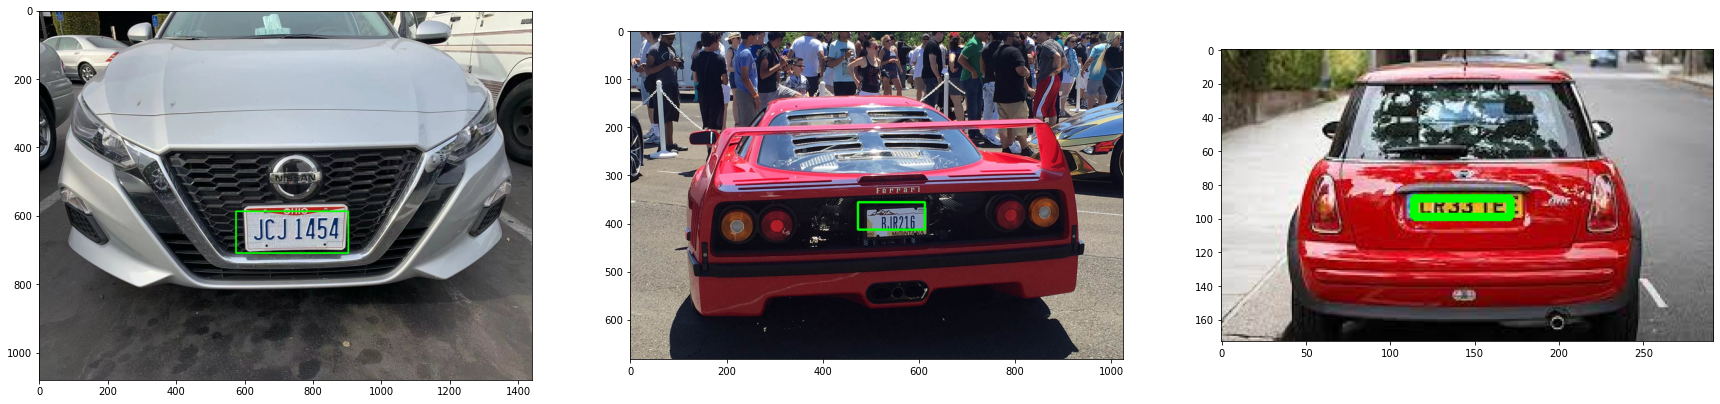

In [27]:
# get the location of the detected plate in original image size
plate_location_origianl_scale = list()
for i in range(len(test_image_orginal_size)):
  # this is the location before normalization
  plate_location_resized = plate_location[i] * 200
  test_image_size = test_image_orginal_size[i]
  height, width = test_image_size[0], test_image_size[1]

  original_xMax = plate_location_resized[0] * (width / IMAGE_RESIZE_X)
  original_xMin = plate_location_resized[1] * (width / IMAGE_RESIZE_X)
  original_yMax = plate_location_resized[2] * (height / IMAGE_RESIZE_Y)
  original_yMin = plate_location_resized[3] * (height / IMAGE_RESIZE_Y)
  plate_location_origianl_scale.append([int(original_xMax), int(original_xMin), int(original_yMax), int(original_yMin)])

# plot the detected plate with car in the orginal images
plt.figure(figsize=(30,10))
for i in range(len(orginal_test_image_list)):
  plt.subplot(1, len(orginal_test_image_list), i+1)

  # copy the original image so that the original image stays unchanged
  image_copy = orginal_test_image_list[i].copy()

  # locate the corner of the plate
  top_left = (plate_location_origianl_scale[i][1], plate_location_origianl_scale[i][3])
  bottom_right = (plate_location_origianl_scale[i][0], plate_location_origianl_scale[i][2])

  # display plates
  cv2.rectangle(image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=3)
  plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))

## Increase the size of the bounding box 

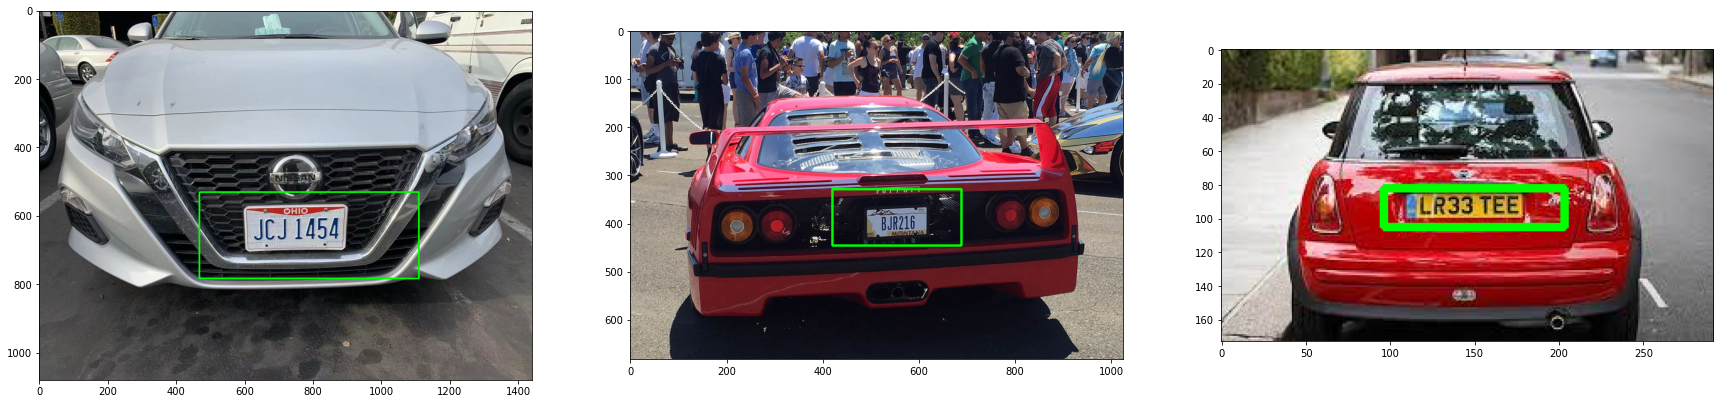

In [28]:
# since the CNN can not predict the plate location with 100% accuracy, we can enlarge
# the size of the bounding box so that it(hopefully) covers the complete plate
plate_image_list = list()

# plot the detected plate with car in the orginal images
plt.figure(figsize=(30,10))
for i in range(len(orginal_test_image_list)):
  plt.subplot(1, len(orginal_test_image_list), i+1)

  # copy the original image so that the original image stays unchanged
  image_copy = orginal_test_image_list[i].copy()

  image_size = test_image_orginal_size[i]
  image_height = image_size[0]
  image_width = image_size[1]

  box_image_ratio_height = (plate_location_origianl_scale[i][2] - plate_location_origianl_scale[i][3]) / image_height
  box_image_ratio_width = (plate_location_origianl_scale[i][0] - plate_location_origianl_scale[i][1]) / image_width

  height_coef = 1 + ((1 / (np.log(box_image_ratio_height))**2) / 2)
  width_coef = 1 + ((1 / (np.log(box_image_ratio_width))**2) / 2)
  #print(height_coef, width_coef)

  # locate the corner of the plate
  top_left = (int(plate_location_origianl_scale[i][1] / width_coef), int(plate_location_origianl_scale[i][3] / height_coef))
  bottom_right = (int(plate_location_origianl_scale[i][0] * width_coef), int(plate_location_origianl_scale[i][2] * height_coef))

  # display plates
  cv2.rectangle(image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=3)
  plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
  
  plate_image = orginal_test_image_list[i][top_left[1]:bottom_right[1], top_left[0]:bottom_right[0],:]
  plate_image_list.append(plate_image)

## Read the plate and display results

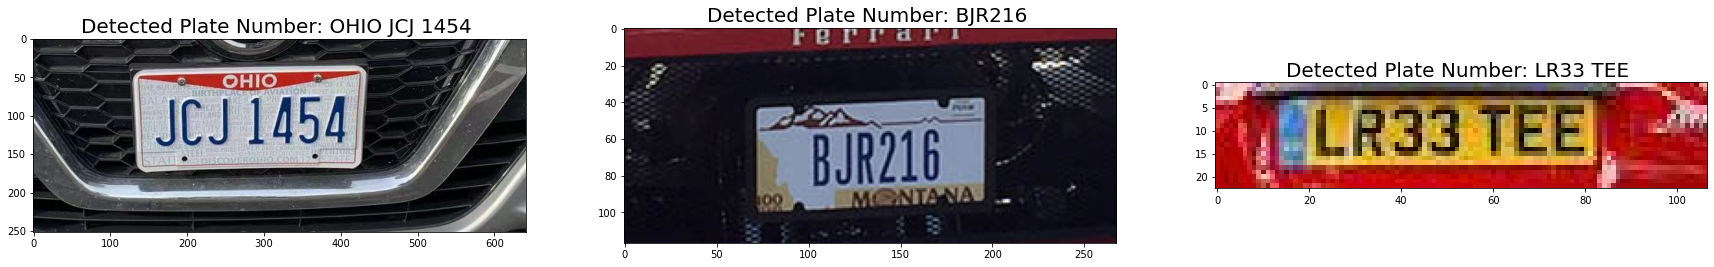

In [47]:
import easyocr

# set up the easyocr reader with english
reader = easyocr.Reader(['en'])

# display the plates with detected text
plt.figure(figsize=(30,10))
for i, plate in enumerate(plate_image_list):
  plt.subplot(1, len(plate_image_list), i+1)
  plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))

  bounds = reader.readtext(plate)
  title_text = ''
  for text in bounds:
    title_text += text[1] + ' '
  plt.title('Detected Plate Number: ' + title_text, fontdict={'fontsize':20})